## **Importing libraries and datasets**

In [520]:
import numpy as np
import pandas as pd
import datetime as dt
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [521]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [522]:
df_response = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/7105/Campaign Response Model/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/7105/Campaign Response Model/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [523]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [524]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [525]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [526]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')

df_transactions.sort_values(by="trans_date", inplace=True)
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
56171,CS3366,2011-05-16,77,1401.0
77394,CS4165,2011-05-16,97,1401.0
2548,CS1849,2011-05-16,79,1401.0
57968,CS4432,2011-05-16,41,1401.0
80045,CS5573,2011-05-16,93,1401.0


In [527]:
## create data set with RFM variables
df_transactions['tran_amount_dup'] = df_transactions['tran_amount']
df_transactions['tran_amount_dup2'] = df_transactions['tran_amount']
df_transactions['trans_date_dup'] = df_transactions['trans_date']

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),
                                                     'tran_amount_dup': lambda x: x.median(),
                                                     'tran_amount_dup2': lambda x: x.std(),
                                                     'trans_date_dup': lambda x: x.diff().mean().days})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'tran_amount_dup': 'extra',
                       'tran_amount_dup2': 'extra2'}, inplace=True)

In [528]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value,extra,extra2,trans_date_dup
0,CS1112,62.0,15,1012,63.0,19.766012,93
1,CS1113,36.0,20,1490,79.5,21.254102,71
2,CS1114,33.0,19,1432,79.0,21.341692,72
3,CS1115,12.0,22,1659,72.5,18.151896,62
4,CS1116,204.0,13,857,60.0,22.940000,96


In [519]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days, # AOU
                                                     'tran_amount_dup': lambda x: x.max(),
                                                     'tran_amount_dup2': lambda x: x.std(),
                                                     'trans_date_dup': lambda x: x.diff().mean().days})       

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU',
                       'tran_amount_dup': 'extra',
                       'tran_amount_dup2': 'extra2'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']
df_clv['rec2'] = df_clv['recency'] ** 2
df_clv['fre2'] = df_clv['frequency'] ** 2

In [529]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,extra,extra2,trans_date_dup,ticket_size,rec2,fre2
0,CS1112,62.0,15,1012,1309,105,19.766012,93,67.466667,3844.0,225
1,CS1113,36.0,20,1490,1354,98,21.254102,71,74.500000,1296.0,400
2,CS1114,33.0,19,1432,1309,105,21.341692,72,75.368421,1089.0,361
3,CS1115,12.0,22,1659,1303,104,18.151896,62,75.409091,144.0,484
4,CS1116,204.0,13,857,1155,105,22.940000,96,65.923077,41616.0,169


## **Calculating response rate**

In [530]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


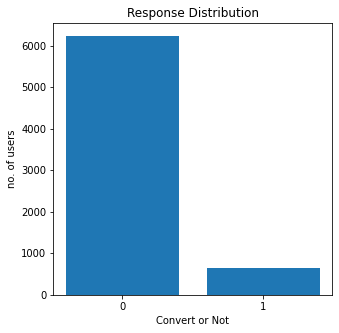

In [531]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [532]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value,extra,extra2,trans_date_dup
0,CS1112,0,62.0,15,1012,63.0,19.766012,93
1,CS1113,0,36.0,20,1490,79.5,21.254102,71
2,CS1114,1,33.0,19,1432,79.0,21.341692,72
3,CS1115,1,12.0,22,1659,72.5,18.151896,62
4,CS1116,1,204.0,13,857,60.0,22.940000,96


In [533]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,extra,extra2,trans_date_dup,ticket_size,rec2,fre2
0,CS1112,0,62.0,15,1012,1309,105,19.766012,93,67.466667,3844.0,225
1,CS1113,0,36.0,20,1490,1354,98,21.254102,71,74.500000,1296.0,400
2,CS1114,1,33.0,19,1432,1309,105,21.341692,72,75.368421,1089.0,361
3,CS1115,1,12.0,22,1659,1303,104,18.151896,62,75.409091,144.0,484
4,CS1116,1,204.0,13,857,1155,105,22.940000,96,65.923077,41616.0,169


## **Creating train and test dataset**

In [534]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [535]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

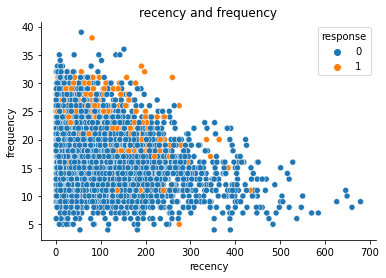

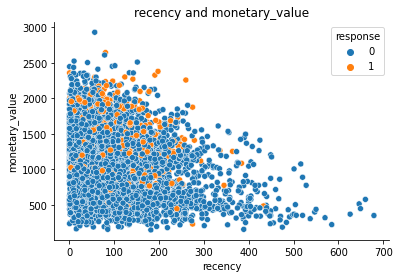

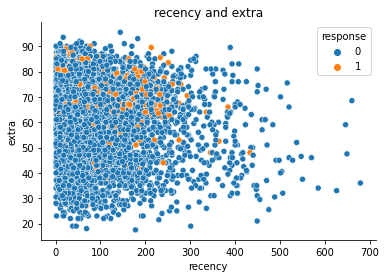

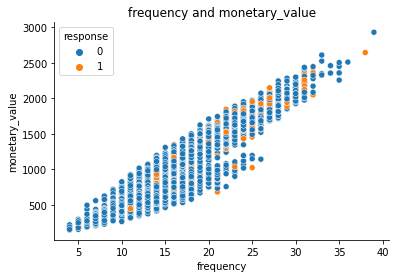

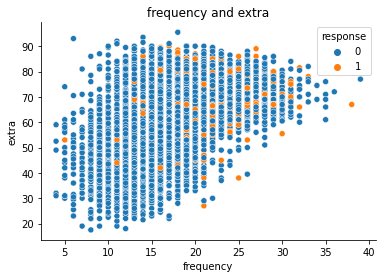

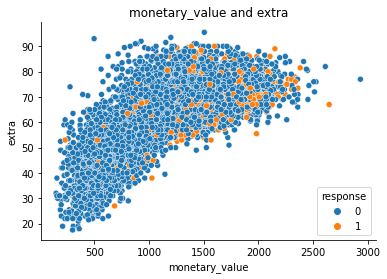

In [536]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value','extra']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value','extra']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

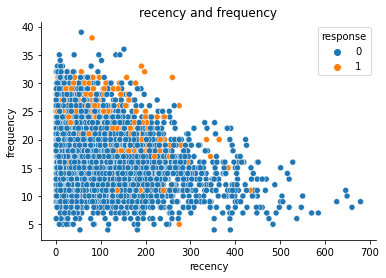

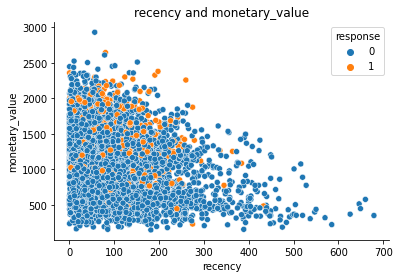

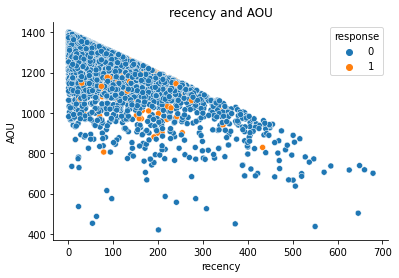

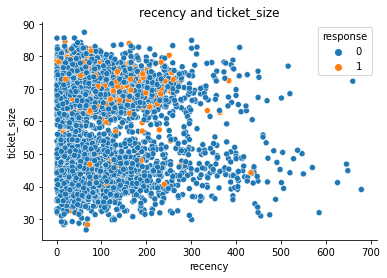

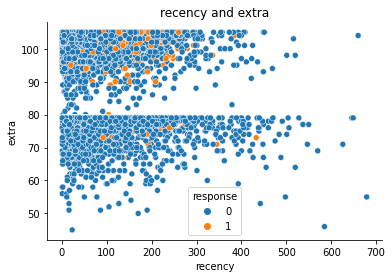

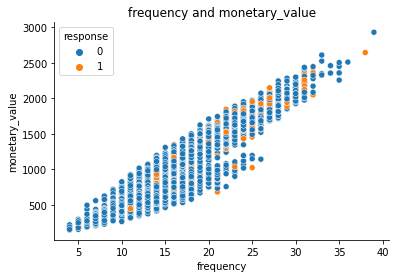

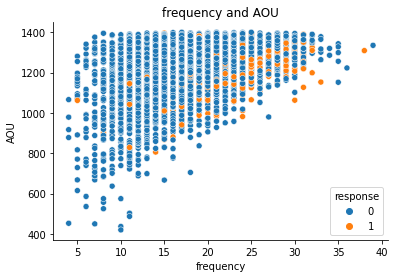

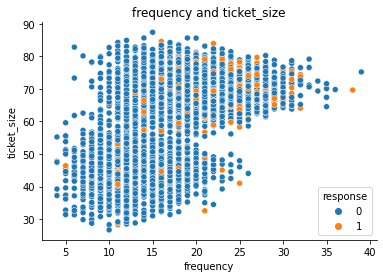

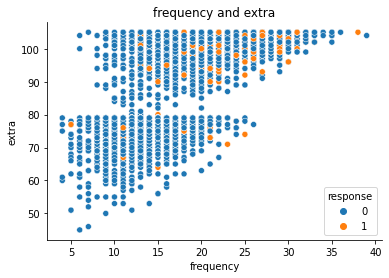

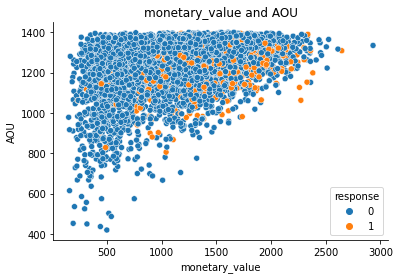

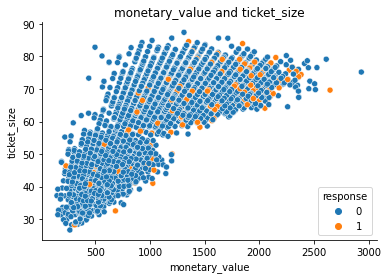

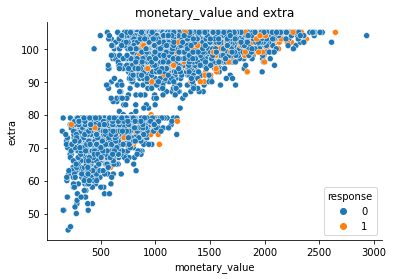

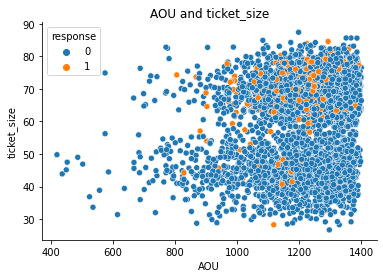

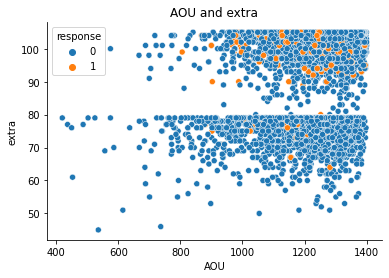

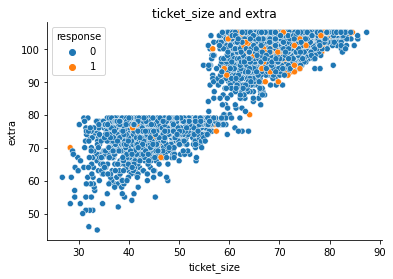

In [537]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size','extra']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size','extra']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [538]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [539]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.70      0.58      0.63      4389
           1       0.64      0.75      0.69      4389

    accuracy                           0.66      8778
   macro avg       0.67      0.66      0.66      8778
weighted avg       0.67      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.58      0.72      1848
           1       0.18      0.81      0.30       218

    accuracy                           0.60      2066
   macro avg       0.57      0.69      0.51      2066
weighted avg       0.88      0.60      0.68      2066



In [540]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      4389
           1       0.65      0.73      0.69      4389

    accuracy                           0.66      8778
   macro avg       0.67      0.66      0.66      8778
weighted avg       0.67      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      1848
           1       0.19      0.77      0.30       218

    accuracy                           0.63      2066
   macro avg       0.57      0.69      0.52      2066
weighted avg       0.88      0.63      0.70      2066



## **XGBoost**

In [541]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.67249
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.697012
[2]	validation_0-auc:0.712621
[3]	validation_0-auc:0.717084
[4]	validation_0-auc:0.724189
[5]	validation_0-auc:0.729751
[6]	validation_0-auc:0.725988
[7]	validation_0-auc:0.726534
[8]	validation_0-auc:0.729093
[9]	validation_0-auc:0.736016
[10]	validation_0-auc:0.736344
[11]	validation_0-auc:0.72964
[12]	validation_0-auc:0.728618
[13]	validation_0-auc:0.733168
[14]	validation_0-auc:0.733482
[15]	validation_0-auc:0.733291
Stopping. Best iteration:
[10]	validation_0-auc:0.736344

training set
              precision    recall  f1-score   support

           0       0.77      0.54      0.63      4389
           1       0.65      0.84      0.73      4389

    accuracy                           0.69      8778
   macro avg       0.71      0.69      0.68      8778
weighted avg       0.71      0.69      0.68      8778

test set
              precis

In [542]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print(xgb_model.feature_importances_)
print(X_train_clv.iloc[0])

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.706164
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.696507
[2]	validation_0-auc:0.710988
[3]	validation_0-auc:0.722877
[4]	validation_0-auc:0.707023
[5]	validation_0-auc:0.707798
[6]	validation_0-auc:0.710514
[7]	validation_0-auc:0.712453
[8]	validation_0-auc:0.711906
Stopping. Best iteration:
[3]	validation_0-auc:0.722877

training set
              precision    recall  f1-score   support

           0       0.79      0.50      0.62      4389
           1       0.64      0.87      0.73      4389

    accuracy                           0.69      8778
   macro avg       0.72      0.69      0.68      8778
weighted avg       0.72      0.69      0.68      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.51      0.66      1848
           1       0.17      0.83      0.28       218

    accuracy                           0.54      2066
   macro avg     

In [543]:
print('XGBoost RF model - SMOTE CLV')

xgb_model = xgb.XGBRFClassifier(eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost RF model - SMOTE CLV
[0]	validation_0-auc:0.713784
Will train until validation_0-auc hasn't improved in 5 rounds.
training set
              precision    recall  f1-score   support

           0       0.79      0.52      0.63      4389
           1       0.64      0.86      0.74      4389

    accuracy                           0.69      8778
   macro avg       0.72      0.69      0.68      8778
weighted avg       0.72      0.69      0.68      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.52      0.67      1848
           1       0.17      0.81      0.28       218

    accuracy                           0.55      2066
   macro avg       0.56      0.67      0.47      2066
weighted avg       0.88      0.55      0.63      2066



In [544]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [545]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.7min finished


In [548]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_train_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_train_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_train_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7243285285347192
[[2682 1707]
 [ 112  317]]
test set
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      4389
           1       0.16      0.74      0.26       429

    accuracy                           0.62      4818
   macro avg       0.56      0.68      0.50      4818
weighted avg       0.89      0.62      0.70      4818



In [549]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7243285285347192
[[1120  728]
 [  55  163]]
test set
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1848
           1       0.18      0.75      0.29       218

    accuracy                           0.62      2066
   macro avg       0.57      0.68      0.52      2066
weighted avg       0.87      0.62      0.69      2066



In [547]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7efff44b4710>}
